In [1]:
from keras.datasets import cifar10
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator


from keras.optimizers import adam_v2
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
tf.keras.utils.to_categorical

<function keras.utils.np_utils.to_categorical>

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


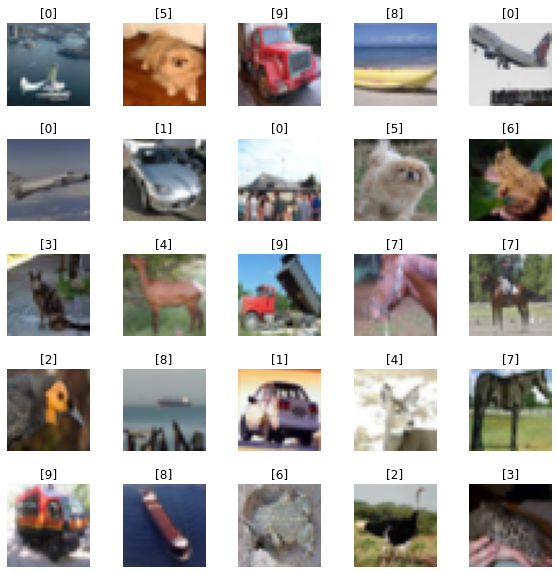

In [3]:
W_grid=5
L_grid=5
fig,axes = plt.subplots(L_grid,W_grid,figsize=(10,10))
axes=axes.ravel()
n_training=len(x_train)
for i in np.arange(0,L_grid * W_grid):
    index=np.random.randint(0,n_training) 
    axes[i].imshow(x_train[index])
    axes[i].set_title(y_train[index]) 
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

In [4]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [5]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [6]:
y_train=tf.keras.utils.to_categorical(y_train)
y_val=tf.keras.utils.to_categorical(y_val)
y_test=tf.keras.utils.to_categorical(y_test)

In [7]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [8]:
train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 

In [9]:
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [11]:
lrr= ReduceLROnPlateau(
                       monitor='val_accuracy', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-6) #The minimum learning rate 

In [ ]:
#Defining the VGG Convolutional Neural Net
base_model = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

In [13]:
#Adding the final layers to the above base models where the actual classification is done in the dense layers

model= Sequential()
model.add(base_model) #Adds the base model (in this case vgg19 to model)
model.add(Flatten()) #Since the output before the flatten layer is a matrix we have to use this function to get a vector of the form nX1 to feed it into the fully connected layers

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.add(Dense(64,activation=('relu'),input_dim=512))
model.add(Dense(64,activation=('relu'))) 
model.add(Dense(128,activation=('relu'))) 
model.add(Dense(128,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(1024,activation=('relu')))

model.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 256)               3

In [17]:
from tensorflow.keras.optimizers import SGD

#Defining the parameters
batch_size= 128
epochs=160
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [18]:
#Compiling the model
#During model compiling the 3 main things we specify are loss function,optimizer and the metrics that need to be evaluated during the test and train processes.
#Lets start by using the SGD optimizer
#We will specify the loss as categoricl crossentropy since the labels are 1 hot encoded. IF we had integer labels,we'd have to use sparse categorical crossentropy as loss function.
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
#Training the model
model.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),
                      callbacks=[lrr],verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/160
273/273 [==============================] - 81s 249ms/step - loss: 1.3218 - accuracy: 0.5303 - val_loss: 0.8959 - val_accuracy: 0.6929 - lr: 0.0010
Epoch 2/160
273/273 [==============================] - 66s 240ms/step - loss: 0.8039 - accuracy: 0.7259 - val_loss: 0.7485 - val_accuracy: 0.7429 - lr: 0.0010
Epoch 3/160
273/273 [==============================] - 65s 240ms/step - loss: 0.6766 - accuracy: 0.7731 - val_loss: 0.6917 - val_accuracy: 0.7679 - lr: 0.0010
Epoch 4/160
273/273 [==============================] - 66s 241ms/step - loss: 0.5860 - accuracy: 0.8031 - val_loss: 0.6065 - val_accuracy: 0.7949 - lr: 0.0010
Epoch 5/160
273/273 [==============================] - 66s 240ms/step - loss: 0.5280 - accuracy: 0.8179 - val_loss: 0.6252 - val_accuracy: 0.7931 - lr: 0.0010
Epoch 6/160
273/273 [==============================] - 65s 240ms/step - loss: 0.4757 - accuracy: 0.8373 - val_loss: 0.6010 - val_accuracy: 0.8067 - lr: 0.0010
Epoch 7/160
273/273 [=========================

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
metrics = pd.DataFrame(model.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy,lr
0,1.321797,0.530311,0.895910,0.692933,1.000000e-03
1,0.803876,0.725941,0.748538,0.742867,1.000000e-03
2,0.676629,0.773113,0.691712,0.767867,1.000000e-03
3,0.585983,0.803109,0.606467,0.794867,1.000000e-03
4,0.528002,0.817934,0.625185,0.793067,1.000000e-03
...,...,...,...,...,...
155,0.016755,0.994924,0.728413,0.858600,1.000000e-06
156,0.015787,0.995383,0.725728,0.857867,1.000000e-06
157,0.017435,0.994924,0.734904,0.856733,1.000000e-06
158,0.016844,0.995182,0.730609,0.857200,1.000000e-06


Text(0.5, 0, 'Epoch')

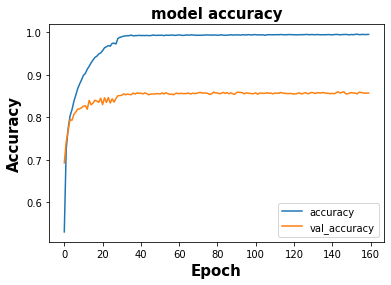

In [21]:
metrics[['accuracy', 'val_accuracy']].plot()
plt.title("model accuracy",fontweight='bold',fontsize=15)
plt.ylabel("Accuracy",fontweight='bold',fontsize=15)
plt.xlabel("Epoch",fontweight='bold',fontsize=15)

Text(0.5, 0, 'Epoch')

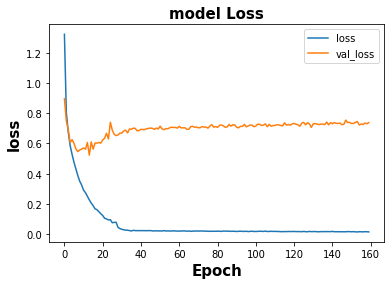

In [22]:
metrics[['loss', 'val_loss']].plot()
plt.title("model Loss",fontweight='bold',fontsize=15)
plt.ylabel("loss",fontweight='bold',fontsize=15)
plt.xlabel("Epoch",fontweight='bold',fontsize=15)

In [23]:
#Making prediction
y_predict = np.argmax(model.predict(x_test), axis=-1)
y_true=np.argmax(y_test,axis=1)

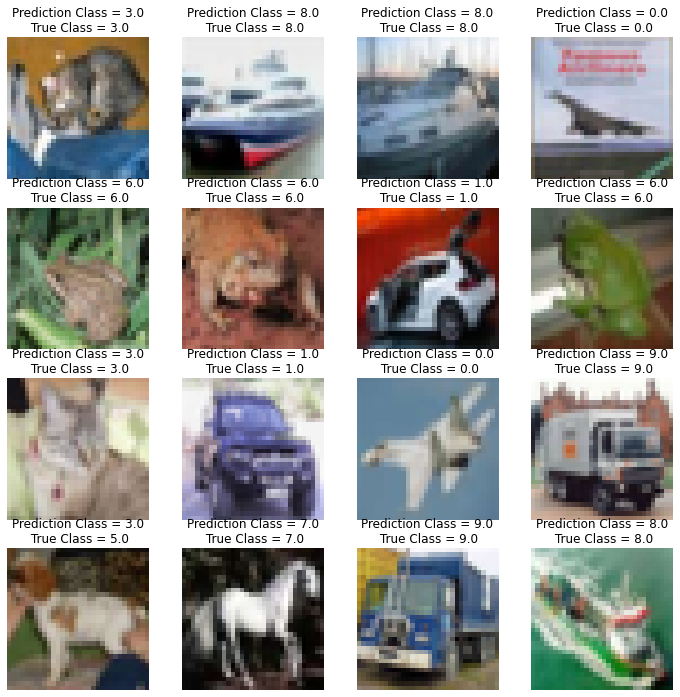

In [24]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(x_test[i])
    axes[i].set_title(f"Prediction Class = {y_predict[i]:0.1f}\n True Class = {y_true[i]:0.1f}")
    axes[i].axis('off')

In [25]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_predict, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_predict)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [26]:
#Plotting the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_predict)

In [27]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Confusion matrix, without normalization


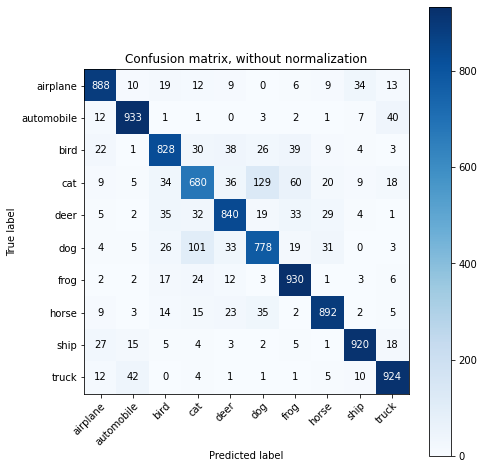

In [28]:
# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


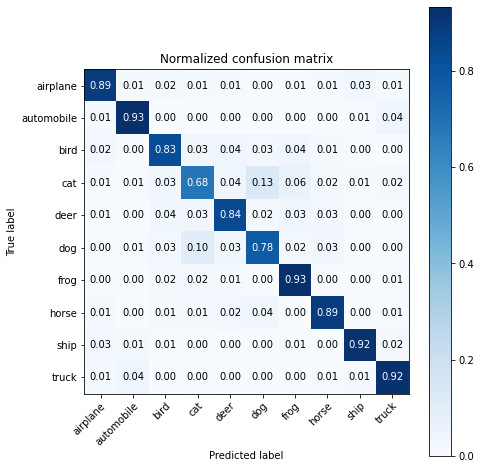

In [29]:
plot_confusion_matrix(y_true, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_predict))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1000
           1       0.92      0.93      0.92      1000
           2       0.85      0.83      0.84      1000
           3       0.75      0.68      0.71      1000
           4       0.84      0.84      0.84      1000
           5       0.78      0.78      0.78      1000
           6       0.85      0.93      0.89      1000
           7       0.89      0.89      0.89      1000
           8       0.93      0.92      0.92      1000
           9       0.90      0.92      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

